In [1]:
from models import *
from priors_new import *
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [82]:
model_prior = GaussianMixture(latent_dim=1, num_clusters=5)
model_encoder = build_encoder(dim_x=100, h_dim=64, n_layers=2)
model_decoder = build_decoder(dim_x=100, latent_dim=1, h_dim=64, n_layers=2)
#opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
model = EmpiricalBayesVariationalAutoencoder(encoder=model_encoder, enc_out_dim=64, decoder=model_decoder, prior=model_prior)

In [83]:
@torch.no_grad()
def generate_clustered_gauss_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,          # 1D latent space
    sigma_val: float = 0.5,       # observation noise std for Gaussian in feature space
    cluster_centers=None,         # if None, auto-generate
    cluster_spread: float = 0.2,  # smaller => tighter clusters in latent space
    seed: int = 42,
    device: str = "cpu",
):
    """
    Build a clean clusterable dataset with 1D latent space:
      z | c ~ N(center[c], cluster_spread^2) in R^latent_dim
      x | z ~ N(W z + b, sigma^2 I) in R^{n_features}
    Returns:
      X [N, D] (float), labels [N] (long), true Z [N, latent_dim], centers [K, latent_dim]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in latent space (R^{latent_dim})
    if cluster_centers is None:
        # Evenly spaced along the first latent axis; zeros elsewhere if latent_dim>1
        centers_1d = torch.linspace(-2, 2, n_clusters, device=device)
        centers = torch.zeros(n_clusters, latent_dim, device=device)
        centers[:, 0] = centers_1d
    else:
        centers = torch.as_tensor(cluster_centers, dtype=torch.float32, device=device)
        if centers.ndim == 1:
            centers = centers.unsqueeze(1)  # [K,1] if given as list of scalars
        assert centers.shape == (n_clusters, latent_dim), \
            f"centers must be shape ({n_clusters},{latent_dim})"

    # Cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]

    # Latent samples
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster centers

    # Linear map to feature space
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    mean_x = z @ W.T + b  # [N, D]

    # Gaussian observation noise (isotropic)
    if sigma_val <= 0:
        X = mean_x
    else:
        X = mean_x + sigma_val * torch.randn(mean_x.shape, device=mean_x.device, generator=g)

    return X, labels.to("cpu"), z.to("cpu"), centers.to("cpu")

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers = generate_clustered_gauss_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    sigma_val=0.5,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: cuda
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


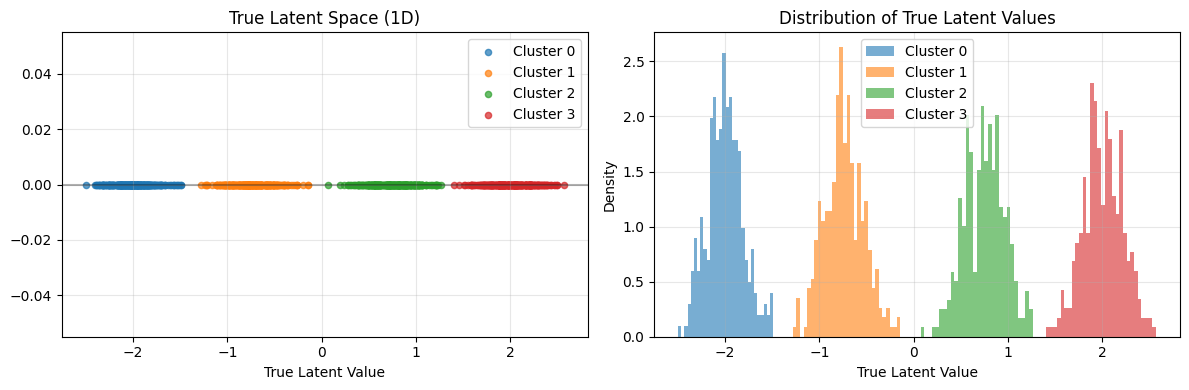

In [85]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [86]:
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [87]:
model.to(device)

EmpiricalBayesVariationalAutoencoder(
  (prior): GaussianMixture()
  (decoder): DiagGaussianDecoder(
    (backbone): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU(inplace=True)
    )
    (mu_head): Linear(in_features=64, out_features=100, bias=True)
    (logvar_head): Linear(in_features=64, out_features=100, bias=True)
  )
  (qz_head): DiagGaussianHead(
    (proj): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
  )
)

In [88]:
model.train()
epochs, kl_warm = 400, 50
losses_history = []

print("Starting training...")
for ep in range(1, epochs+1):
    #kl_w = min(21.0, ep / kl_warm)
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        outputs = model.train_step(xb, opt)
        losses={"loss":outputs["vae-loss"]}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 2 == 0 or ep == epochs:
        #print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")
        print(f"[{ep:03d}] loss={tot/n:.3f}")

print("Training completed!")


Starting training...
[001] loss=5094.106
[002] loss=4499.263
[004] loss=1958.703
[006] loss=263.441
[008] loss=219.103
[010] loss=197.836
[012] loss=186.932
[014] loss=183.726
[016] loss=177.180
[018] loss=173.665
[020] loss=170.284
[022] loss=168.708
[024] loss=165.891
[026] loss=163.262
[028] loss=161.508
[030] loss=159.084
[032] loss=156.588
[034] loss=154.617
[036] loss=152.668
[038] loss=150.840
[040] loss=149.254
[042] loss=147.768
[044] loss=146.742
[046] loss=145.714
[048] loss=144.546
[050] loss=144.072
[052] loss=143.374
[054] loss=143.176
[056] loss=142.898
[058] loss=142.476
[060] loss=142.049
[062] loss=141.894
[064] loss=141.711
[066] loss=141.531
[068] loss=141.375
[070] loss=141.187
[072] loss=141.103
[074] loss=141.011
[076] loss=140.733
[078] loss=140.509
[080] loss=140.628
[082] loss=140.456
[084] loss=140.260
[086] loss=140.346
[088] loss=140.072
[090] loss=139.907
[092] loss=139.879
[094] loss=139.749
[096] loss=139.592
[098] loss=139.526
[100] loss=139.496
[102] l

In [89]:
model.eval()
with torch.no_grad():
    mu_q = model._define_variational_family(X.float().to(device)).mean

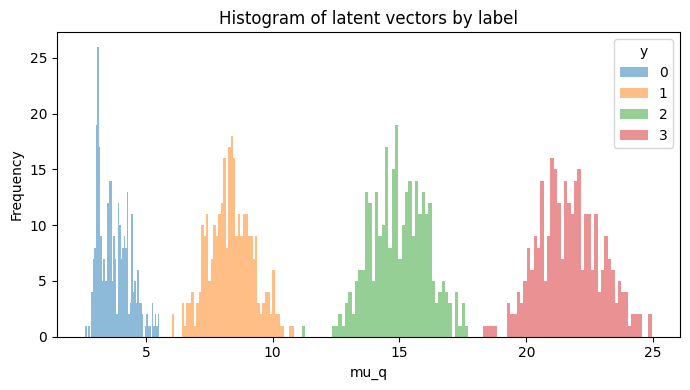

In [90]:
mu = mu_q.detach().flatten().to("cpu").numpy()
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [91]:
mu_q = mu_q.unsqueeze(1)

In [92]:
resp = model.prior.log_prob_c_z(mu_q)

In [93]:
model.prior.mu

Parameter containing:
tensor([[14.1074],
        [ 3.6716],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], device='cuda:0', requires_grad=True)

In [94]:
predict_label = resp.argmax(dim=1).detach().cpu().numpy()

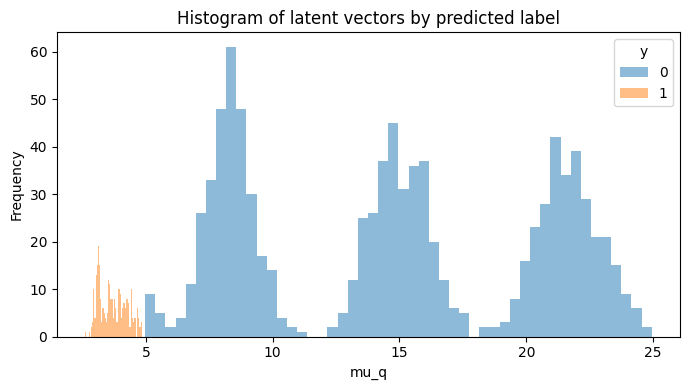

In [95]:
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(predict_label):
    sel = (predict_label == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by predicted label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [66]:
np.where(predict_label==3)

(array([], dtype=int64),)

In [67]:
resp

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ExpBackward0>)